<a href="https://colab.research.google.com/github/kd-kdev/CognitiveRadio-LSTM/blob/main/LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predviđanje stanja kanala uz pomoć LSTM (Long Short-Term Memory) modela
Uz pomoć PyTorch tehnologije, simuliramo više frekventnih kanala kao i njihovu dostupnost kroz vreme.
Koristimo LSTM model koji treniramo na simulaciji jednog spektra i pravimo predviđanja o budućim stanjima spektra na osnovu njegovih prethodnih stanja.

Rad se sastoji iz sledećih delova:
1. Importujemo neophodne biblioteke
2. Simuliramo spektar kao i njegovo stanje kroz vreme koristeći funkciju `simulate_multiple_channels`
3. Pripremamo/obrađujemo podatke u format pogodan za input na LSTM model
4. Definišemo LSTM model
5. Pripremamo DataLoader, spremamo podatke za treniranje
6. Training loop - treniramo model na simuliranim podacima
7. Nasumično odabiramo deo prethodno simuliranih podataka, i predviđamo buduće stanje kanala uz pomoć LSTM modela
8. Proveravamo preciznost modela
9. Poredimo realno stanja kanala sa predviđenim stanjem

>[Predviđanje stanja kanala uz pomoć LSTM (Long Short-Term Memory) modela](#scrollTo=szOWLo_3FYsy)

>[Importing required libraries](#scrollTo=R-uOLgZWcB4I)

>[Simulate channel occupancy](#scrollTo=S51ngni7cNX5)

>[Data preparation](#scrollTo=QwqRX2ZiFgv9)

>[Defining the LSTM model](#scrollTo=xyRWGd5QFigA)

>[Prepare dataset for training using DataLoader](#scrollTo=0B9BdEf3Fk2l)

>[Training loop](#scrollTo=OeuQBRW1Fn3D)

>[Evaluation on sample](#scrollTo=EtUtEXFpFvTz)



# 1. Importing required libraries

In [ ]:
!pip install torchview
!pip install torchviz
!pip install torch-summary

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import random
from torchview import draw_graph
from torchviz import make_dot
from IPython.display import Image
from torchsummary import summary

# 2. Simulate channel occupancy

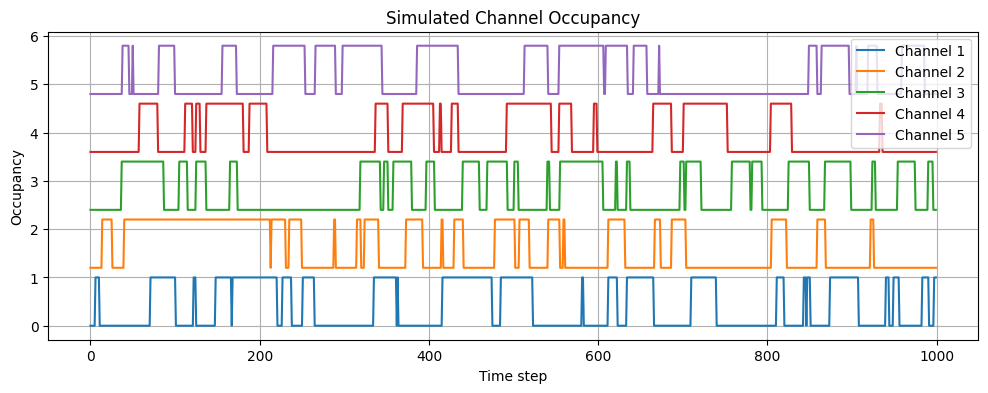

In [ ]:
def simulate_multiple_channels(num_channels=5, length=1000, avg_on_duration=20, avg_off_duration=30):
    channels = []
    for _ in range(num_channels):
        channel = []
        state = 0
        while len(channel) < length:
            duration = np.random.exponential(scale=avg_on_duration if state == 1 else avg_off_duration)
            duration = int(max(1, round(duration)))
            channel.extend([state] * duration)
            state = 1 - state
        channels.append(channel[:length])
    return np.array(channels)

channel_data = simulate_multiple_channels()

# Plot
plt.figure(figsize=(12, 4))
for i in range(channel_data.shape[0]):
    plt.plot(channel_data[i] + i * 1.2, label=f"Channel {i+1}")
plt.title("Simulated Channel Occupancy")
plt.xlabel("Time step")
plt.ylabel("Occupancy")
plt.legend()
plt.grid(True)
plt.show()

# 3. Data preparation

In [ ]:
channel_data = channel_data.T # this transposes it to shape (time_steps, num_channels) for sequence slicing

def create_sequence(channel_data, window_size=100, horizon=10):
  X = [] # sequence of past channel states, contains a fixed length window of past observations
  y = [] # sequence of steps after 10 steps (horizon, the num. of steps in the future we want to predict)
  for i in range(len(channel_data) - window_size - horizon +1):
    X.append(channel_data[i:i+window_size])
    y.append(channel_data[i+window_size : i+window_size+horizon])
  return np.array(X), np.array(y)

X, y = create_sequence(channel_data, window_size=100, horizon=10)
print(f"X.shape = {X.shape}, y.shape = {y.shape}")
# will give you 891 training samples from the dataset, 100 time steps, 5 values per channel

X.shape = (891, 100, 5), y.shape = (891, 10, 5)


# 4. Defining the LSTM model

In [ ]:
class LSTM_model(nn.Module):
  def __init__(self, num_channels, horizon=10, hidden_size=256):
    super().__init__()
    self.horizon = horizon
    self.num_channels = num_channels
    self.lstm = nn.LSTM(input_size=num_channels, hidden_size=hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_channels * horizon)

  def forward(self, x):
    out, _ =self.lstm(x)
    last_out = out[:, -1, :]
    preds = self.fc(last_out)
    preds = preds.view(-1, self.horizon, self.num_channels)
    return torch.sigmoid(preds)

# 5. Prepare dataset for training using DataLoader

In [ ]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)

batch_size = 64 # try out different values like 32 as well
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 6. Training loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training Parameters
num_channels = X.shape[2]  # 5 channels
horizon = y.shape[1]       # 10 time steps ahead
loss_values = []
epochs = 100
lr = 0.001 # learning rate

model = LSTM_model(num_channels=num_channels, horizon=horizon)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

# Variable to track best loss
best_loss = float('inf')
best_model_state = None  # to store the best model

# Training loop
for epoch in range(1, epochs +1):
  model.train()
  epoch_loss = 0.0

  for X_batch, y_batch in dataloader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    optimizer.zero_grad()
    outputs = model(X_batch)
    loss = criterion(outputs, y_batch)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item() * X_batch.size(0)

  avg_loss = epoch_loss / len(dataset)
  loss_values.append(avg_loss)
  print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f}")

  # Save best model
  if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = model.state_dict()  # save model weights
        #print(f"  --> New best loss, saving model.")

# load the best model
model.load_state_dict(best_model_state)
print(f"Training complete. Best loss: {best_loss:.4f}")

Using device: cuda
Epoch 1/100 - Loss: 0.6775
Epoch 2/100 - Loss: 0.6319
Epoch 3/100 - Loss: 0.5976
Epoch 4/100 - Loss: 0.5697
Epoch 5/100 - Loss: 0.5470
Epoch 6/100 - Loss: 0.5260
Epoch 7/100 - Loss: 0.4933
Epoch 8/100 - Loss: 0.4675
Epoch 9/100 - Loss: 0.4355
Epoch 10/100 - Loss: 0.4412
Epoch 11/100 - Loss: 0.4550
Epoch 12/100 - Loss: 0.4219
Epoch 13/100 - Loss: 0.4252
Epoch 14/100 - Loss: 0.4235
Epoch 15/100 - Loss: 0.3855
Epoch 16/100 - Loss: 0.3684
Epoch 17/100 - Loss: 0.3413
Epoch 18/100 - Loss: 0.3242
Epoch 19/100 - Loss: 0.3134
Epoch 20/100 - Loss: 0.3285
Epoch 21/100 - Loss: 0.4648
Epoch 22/100 - Loss: 0.4003
Epoch 23/100 - Loss: 0.3557
Epoch 24/100 - Loss: 0.3284
Epoch 25/100 - Loss: 0.3855
Epoch 26/100 - Loss: 0.3444
Epoch 27/100 - Loss: 0.3089
Epoch 28/100 - Loss: 0.2846
Epoch 29/100 - Loss: 0.2610
Epoch 30/100 - Loss: 0.2546
Epoch 31/100 - Loss: 0.2770
Epoch 32/100 - Loss: 0.2510
Epoch 33/100 - Loss: 0.2256
Epoch 34/100 - Loss: 0.2335
Epoch 35/100 - Loss: 0.2318
Epoch 36/1

Smallest loss is: 0.1193 (Epoch 70)
Largest loss is: 1.0367
Last loss value is: 0.3868


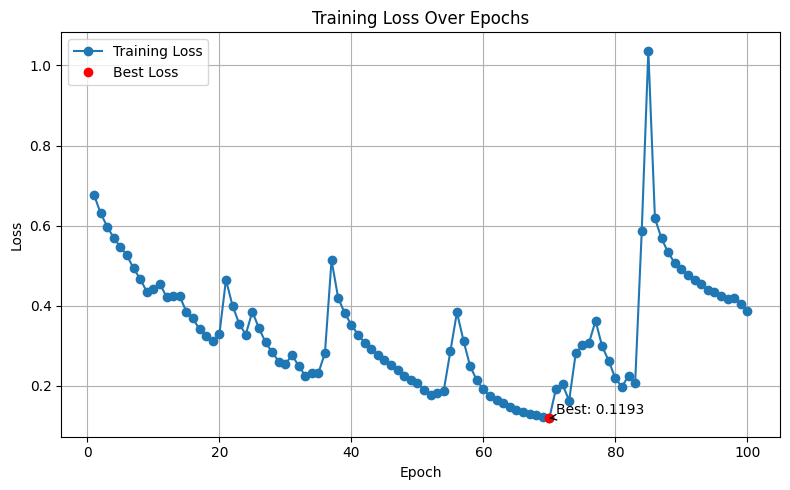

In [ ]:
# Plot loss over epochs with best loss annotated
min_loss_value = min(loss_values)
min_loss_epoch = loss_values.index(min_loss_value) + 1  # +1 because epochs start at 1
max_loss_value = max(loss_values)
last_loss_value = loss_values[epochs-1]

print(f"Smallest loss is: {min_loss_value:.4f} (Epoch {min_loss_epoch})")
print(f"Largest loss is: {max_loss_value:.4f}")
print(f"Last loss value is: {last_loss_value:.4f}")

# Loss curve plot with best loss highlighted
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), loss_values, marker='o', linestyle='-', label='Training Loss')

# Highlight the best loss
plt.plot(min_loss_epoch, min_loss_value, 'ro', label='Best Loss')
plt.annotate(f'Best: {min_loss_value:.4f}',
             xy=(min_loss_epoch, min_loss_value),
             xytext=(min_loss_epoch + 1, min_loss_value + 0.01),
             arrowprops=dict(facecolor='red', arrowstyle='->'))

plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 7. Evaluation on sample

In [ ]:
random_avg_on = random.randint(1, 100)
random_avg_off = random.randint(1, 100)
X_raw = simulate_multiple_channels(num_channels=5, length=1000, avg_on_duration=random_avg_on, avg_off_duration=random_avg_off)
X_raw_T = X_raw.T   # X_raw shape (5,1000) -> (1000,5)

print(f"Generated test data with values:")
print(f"avg_on_duration: {random_avg_on}")
print(f"avg_off_duration: {random_avg_off}")

# Creare sequences
window_size = 100
horizon = 10
test_X, test_y = create_sequence(X_raw_T, window_size, horizon)

test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to(device)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32).to(device)

accuracy_values = []

# load model with smallest loss
model.load_state_dict(best_model_state)
model.to(device)
model.eval()
print(f"Loaded best model with loss: {best_loss:.4f}")

with torch.no_grad():
    preds = model(test_X_tensor)  # shape: (num_samples, horizon, num_channels)

preds_binary = (preds >= 0.5).int() # converts probabilities to either 1 or 0

correct = (preds_binary == test_y_tensor.int()).sum().item()
total = torch.numel(test_y_tensor)
accuracy = correct / total
print(f"Evaluation accuracy on new dataset: {accuracy*100:.2f}%")

accuracy_values.append(accuracy * 100)


# testing
#print(f"preds: {preds}")
#print(f"preds binary: {preds_binary}")
#print(f"test X tensor: {test_X_tensor}")
#print(f"correct: {correct}")
#print(f"total: {total}")

Generated test data with values:
avg_on_duration: 77
avg_off_duration: 14
Loaded best model with loss: 0.1193
Evaluation accuracy on new dataset: 75.53%


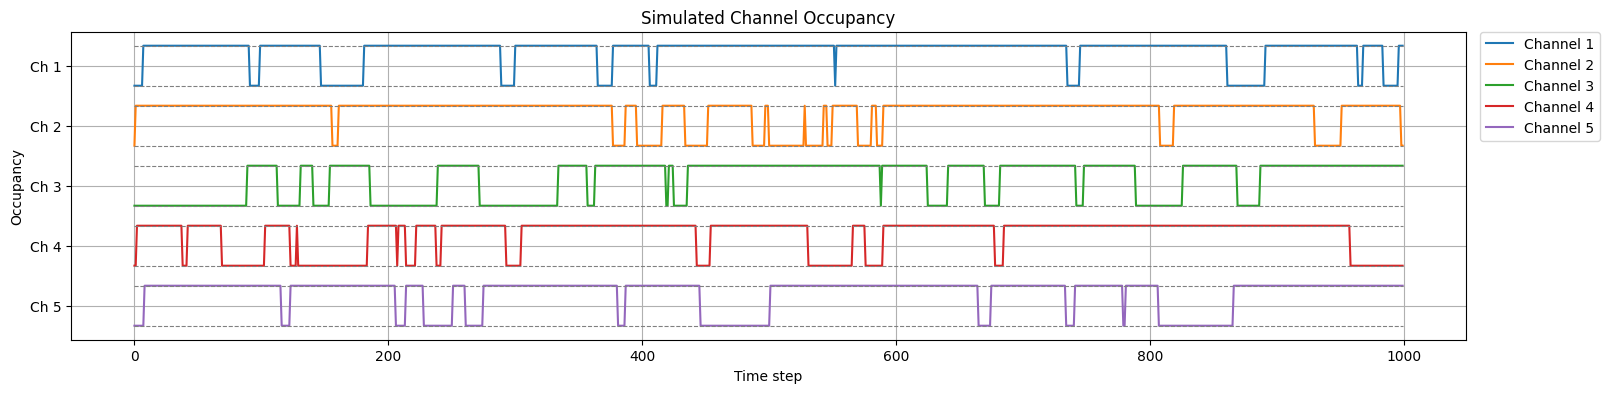

In [ ]:
# Plot for new dataset
offset = 1.5
plt.figure(figsize=(18, 4))

yticks = []
yticklabels = []

for i in range(num_channels):
    rev_i = num_channels - 1 - i
    channel_offset = rev_i * offset

    # Plot actual channel signal
    plt.plot(X_raw[i] + channel_offset, label=f"Channel {i+1}")

    # Add horizontal lines at 0 and 1 for this channel
    plt.hlines(y=channel_offset + 0, xmin=0, xmax=X_raw.shape[1]-1, colors='gray', linestyles='dashed', linewidth=0.8)
    plt.hlines(y=channel_offset + 1, xmin=0, xmax=X_raw.shape[1]-1, colors='gray', linestyles='dashed', linewidth=0.8)

    # Set middle point for tick
    mid = channel_offset + 0.5
    yticks.append(mid)
    yticklabels.append(f"Ch {i+1}")

plt.title("Simulated Channel Occupancy")
plt.xlabel("Time step")
plt.ylabel("Occupancy")
plt.yticks(yticks, yticklabels)
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.grid(True)
plt.show()

Compact comparison graph

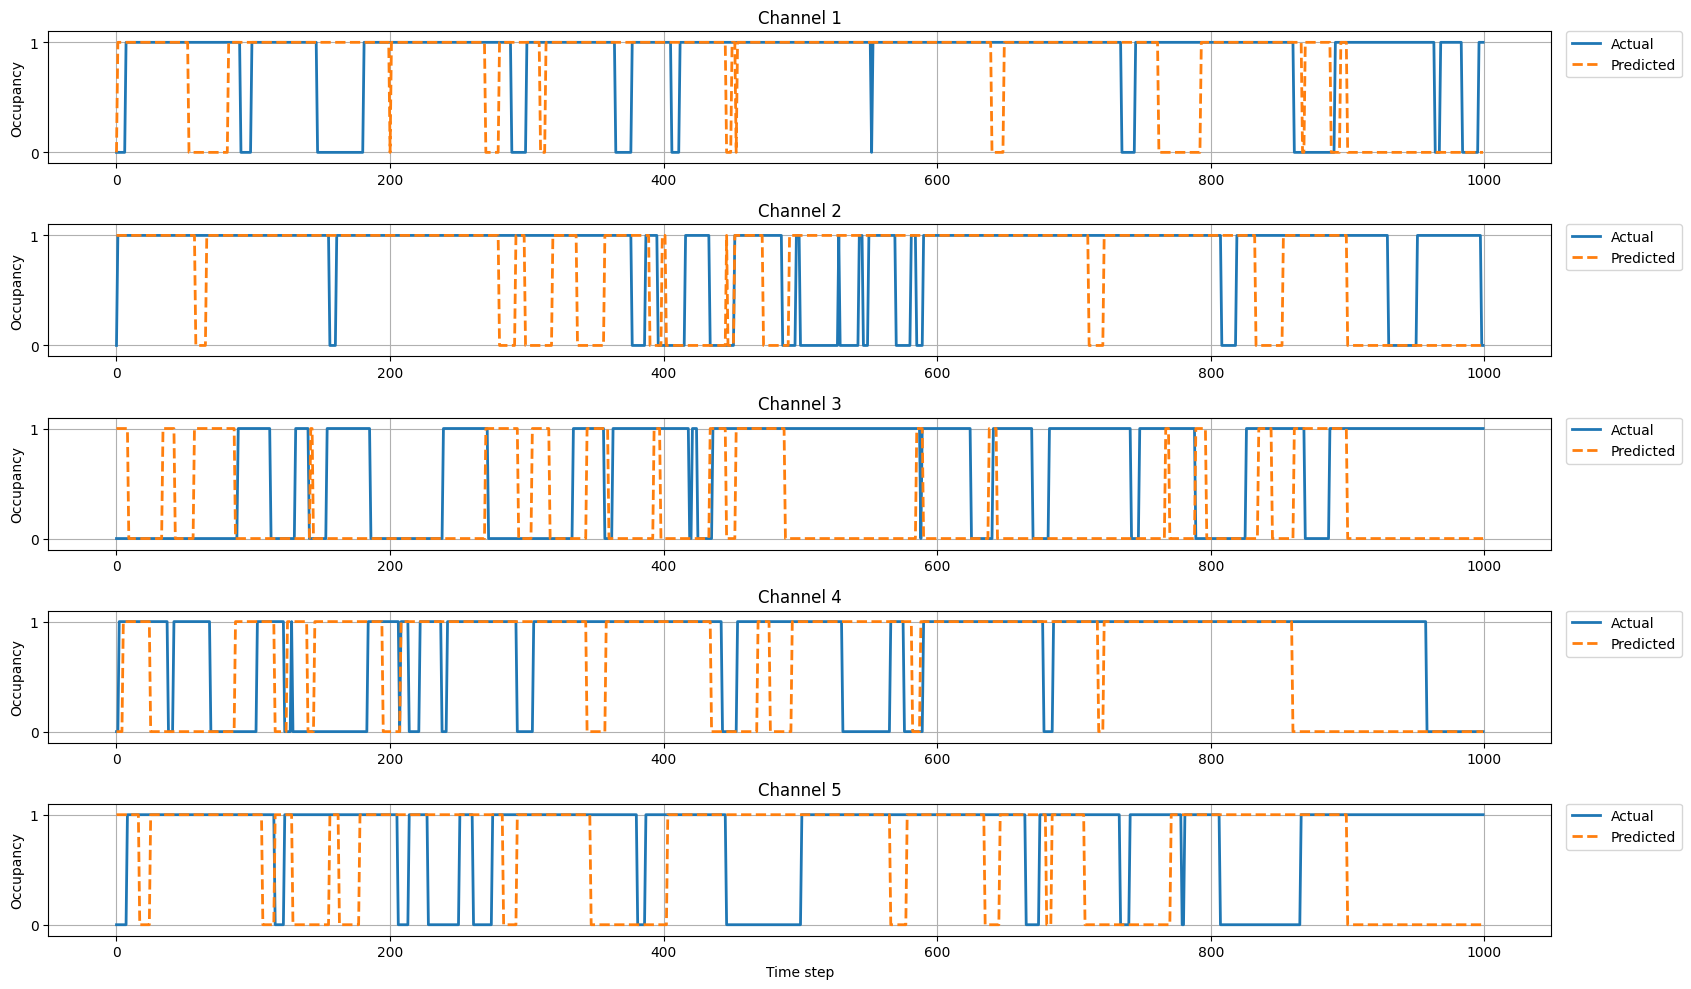

In [ ]:
preds_np = preds_binary.cpu().numpy()  # convert to numpy
num_samples, horizon, num_channels = preds_np.shape

# Initialize array for full length predictions
pred_full = np.zeros((num_channels, X_raw.shape[1]))

# slide horizon predictions over time
for i in range(num_samples):
    start_idx = i
    end_idx = i + horizon
    if end_idx > X_raw.shape[1]:
        end_idx = X_raw.shape[1]
    length = end_idx - start_idx
    pred_full[:, start_idx:end_idx] = preds_np[i, :length, :].T


num_channels = X_raw.shape[0]

fig, axes = plt.subplots(num_channels, 1, figsize=(17, 2*num_channels), sharex=False)

for i in range(num_channels):
    ax = axes[i]
    ax.plot(X_raw[i], label=f"Actual", linewidth=2)
    ax.plot(pred_full[i], '--', label=f"Predicted", linewidth=2)
    ax.set_ylabel("Occupancy")
    ax.set_ylim(-0.1, 1.1)  # keep 0-1 range
    ax.set_yticks([0, 1])  # only show 0 and 1
    ax.set_title(f"Channel {i+1}")
    ax.grid(True)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0)

axes[-1].set_xlabel("Time step")
plt.tight_layout()
plt.show()

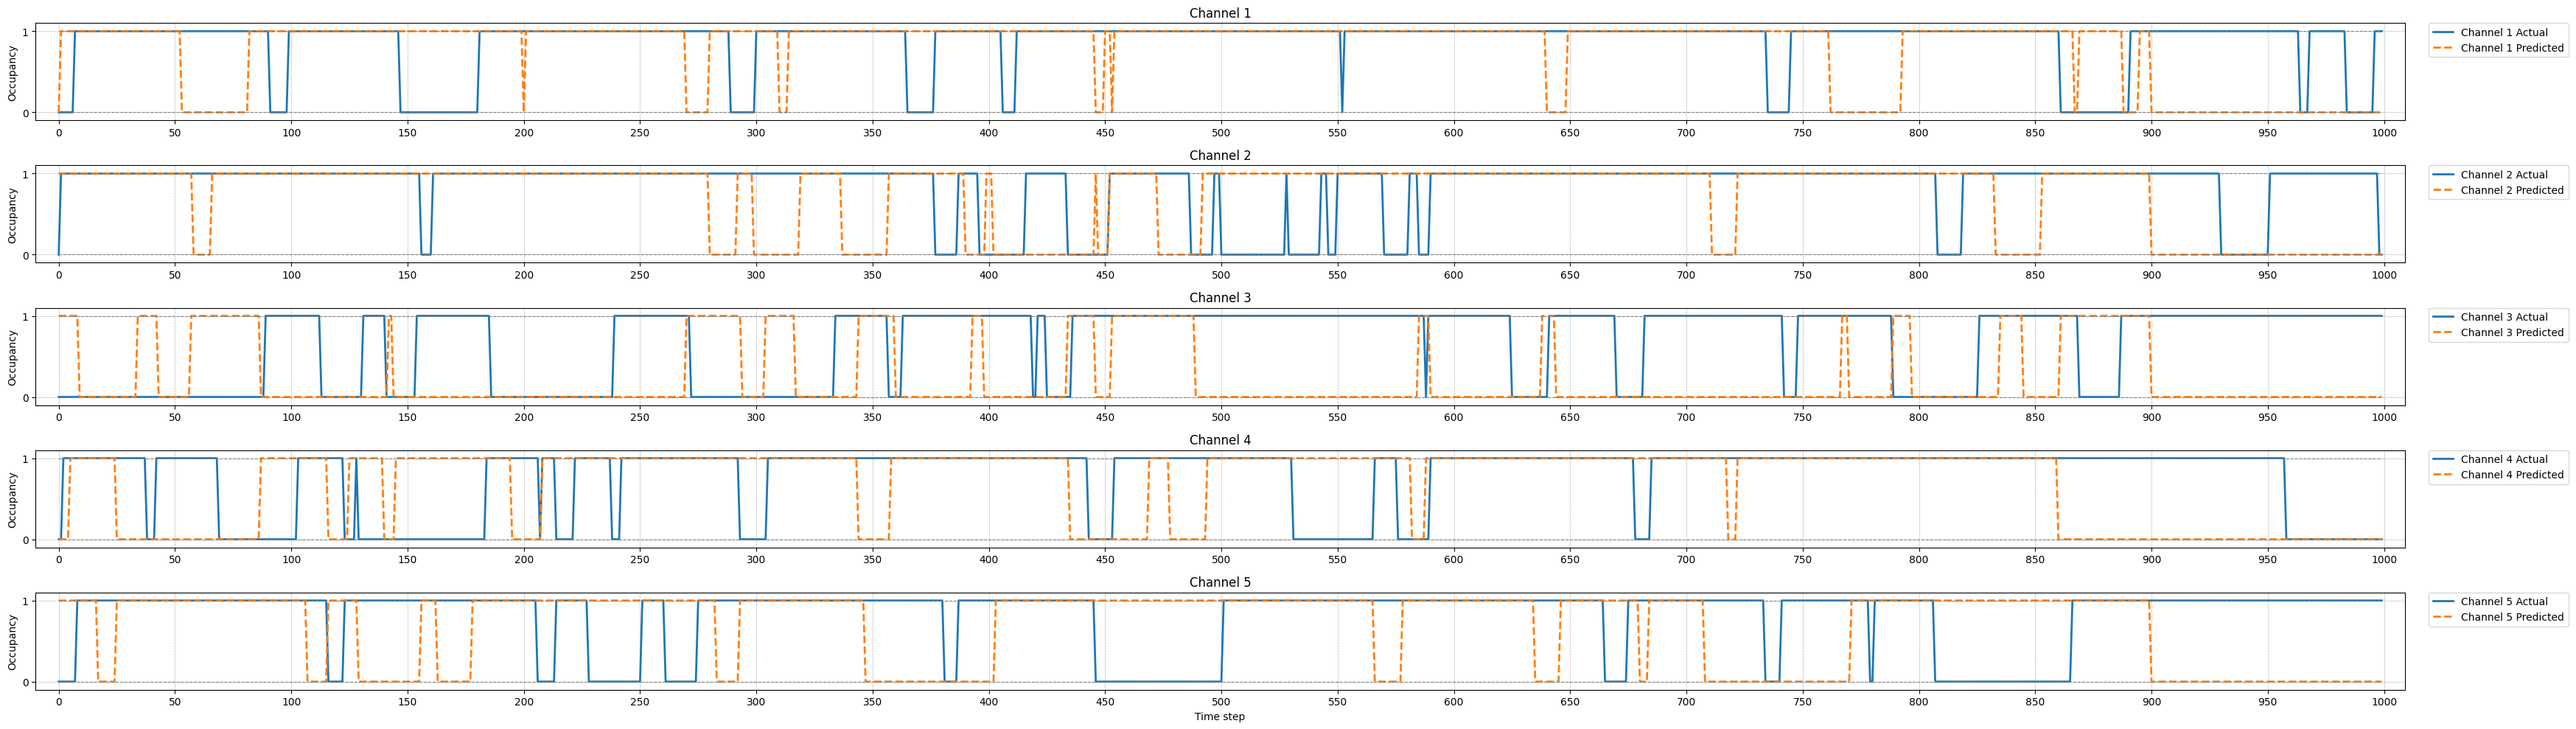

In [ ]:
# Stitches together the 891x10x5 predictions into a 1000-step long prediction signal for each channel
# usable timeline

# Wider graph with more detail
num_channels = X_raw.shape[0]
fig, axes = plt.subplots(num_channels, 1, figsize=(35, 2*num_channels), sharex=False)

for i in range(num_channels):
    ax = axes[i]

    # Solid line for actual
    ax.plot(X_raw[i], label=f"Channel {i+1} Actual", linewidth=2)

    # Dashed line for predicted
    ax.plot(pred_full[i], '--', label=f"Channel {i+1} Predicted", linewidth=2)

    ax.set_ylabel("Occupancy")
    ax.set_ylim(-0.1, 1.1)
    ax.set_yticks([0, 1])
    ax.set_title(f"Channel {i+1}")

    # Horizontal 0/1 guide lines
    ax.hlines([0, 1], xmin=0, xmax=X_raw.shape[1]-1, colors='gray', linestyles='dashed', linewidth=0.8)

    # Vertical guidelines
    ax.set_xticks(np.arange(0, X_raw.shape[1]+1, 50))
    ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0)

    # Remove horizontal padding
    ax.margins(x=0.01)

axes[-1].set_xlabel("Time step")
plt.tight_layout()
plt.show()

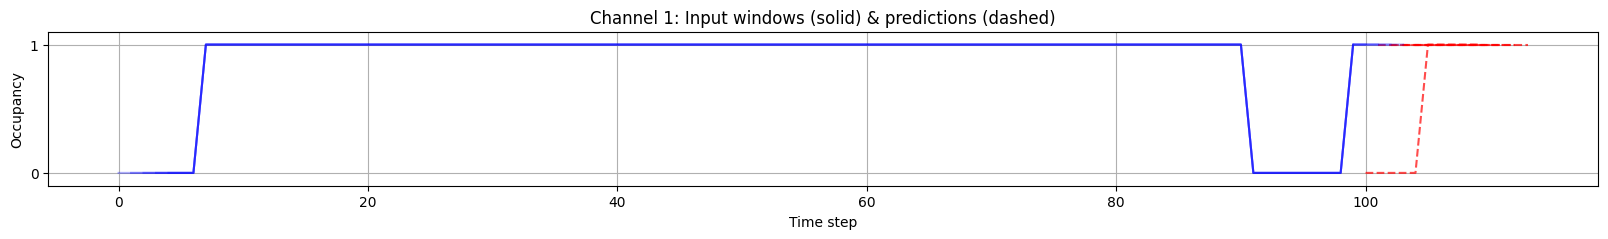

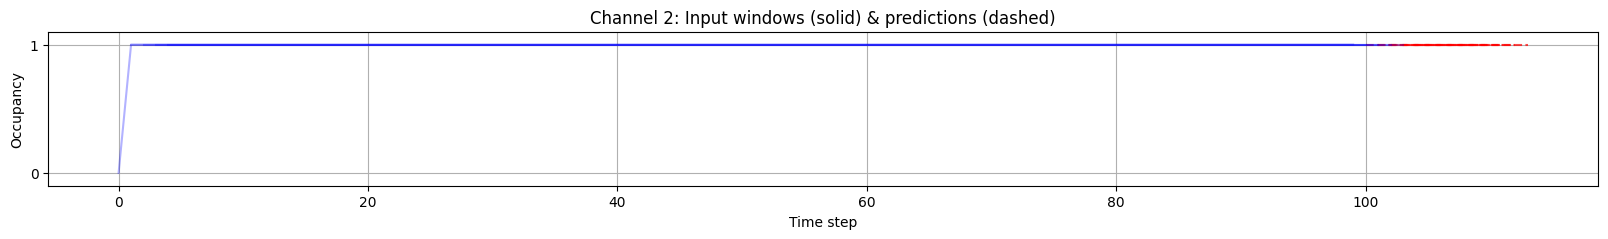

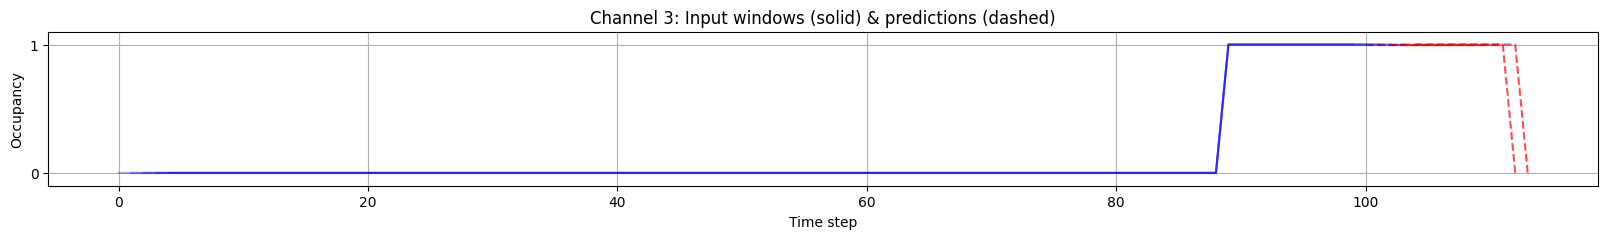

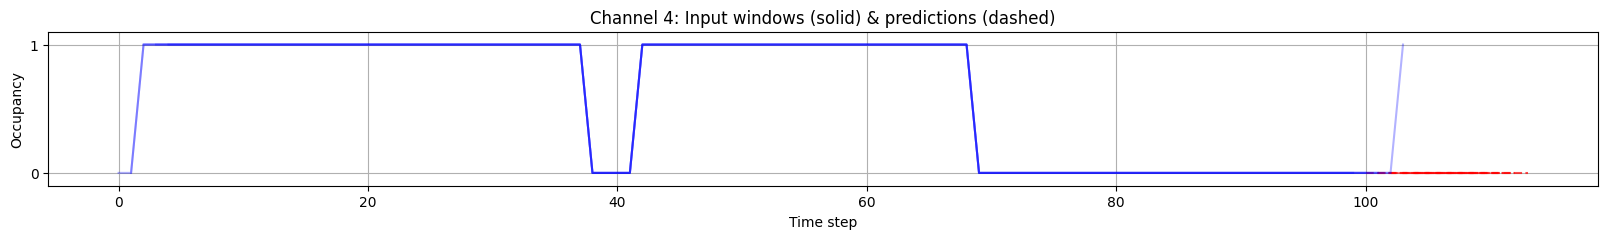

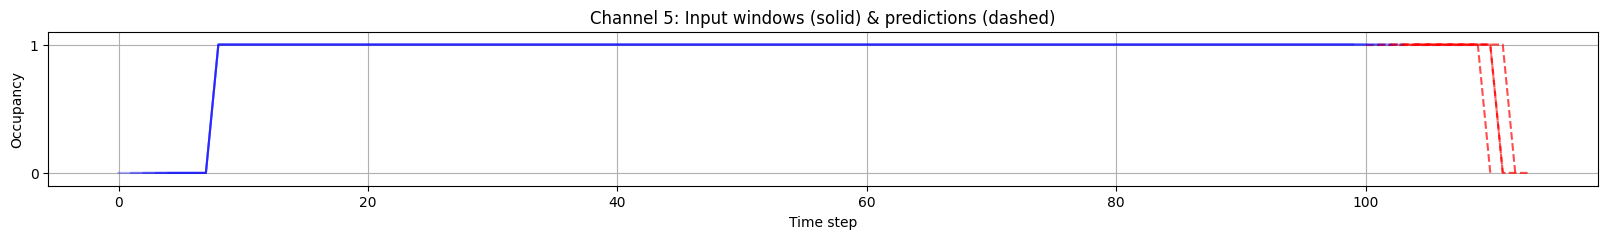

In [ ]:
# TESTING
preds_binary_np = preds_binary.cpu().numpy()
num_channels = X_raw.shape[0]
num_windows_to_plot = 5  # plot first 5 windows

for i in range(num_channels):
    plt.figure(figsize=(20, 2))
    for w in range(num_windows_to_plot):
        start_input = w
        end_input = w + 100
        start_pred = end_input
        end_pred = start_pred + 10

        # Plot input (solid line)
        plt.plot(range(start_input, end_input), X_raw[i, start_input:end_input], color='blue', alpha=0.3)

        # Plot prediction (dashed line)
        plt.plot(range(start_pred, end_pred), preds_binary_np[w, :, i], '--', color='red', alpha=0.7)

    plt.title(f"Channel {i+1}: Input windows (solid) & predictions (dashed)")
    plt.xlabel("Time step")
    plt.ylabel("Occupancy")
    plt.ylim(-0.1, 1.1)
    plt.yticks([0, 1])
    plt.grid(True)
    plt.show()


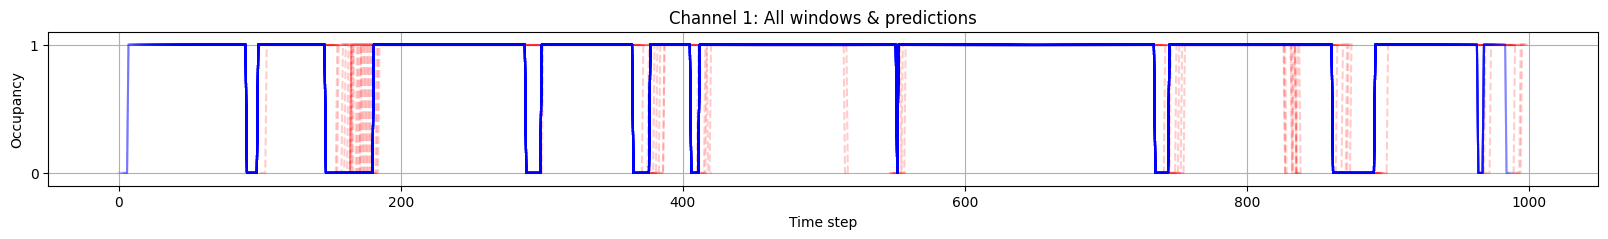

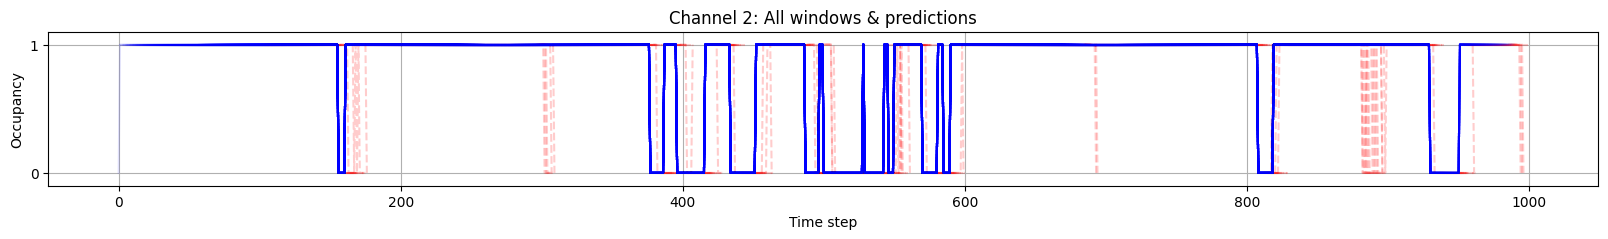

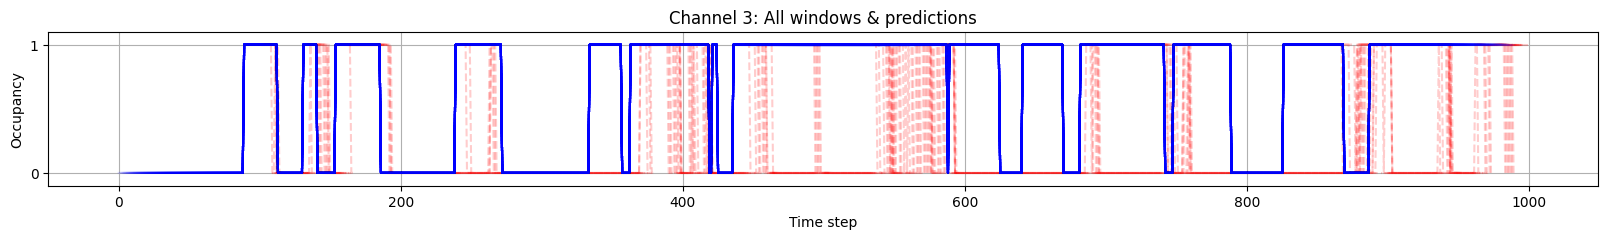

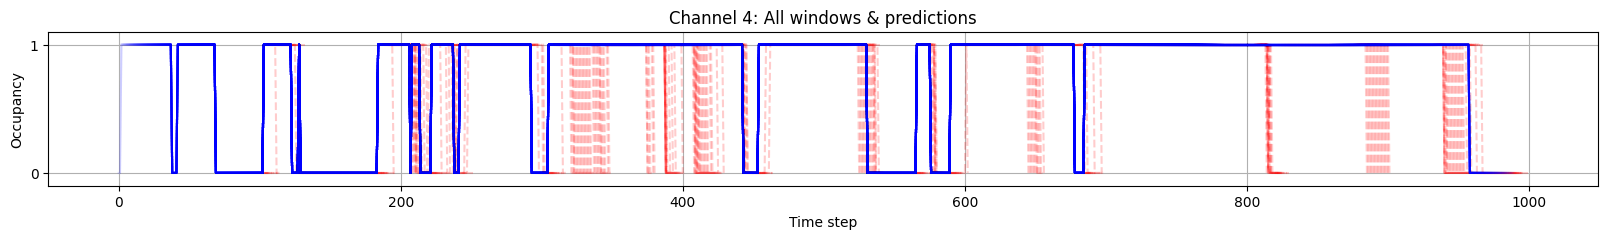

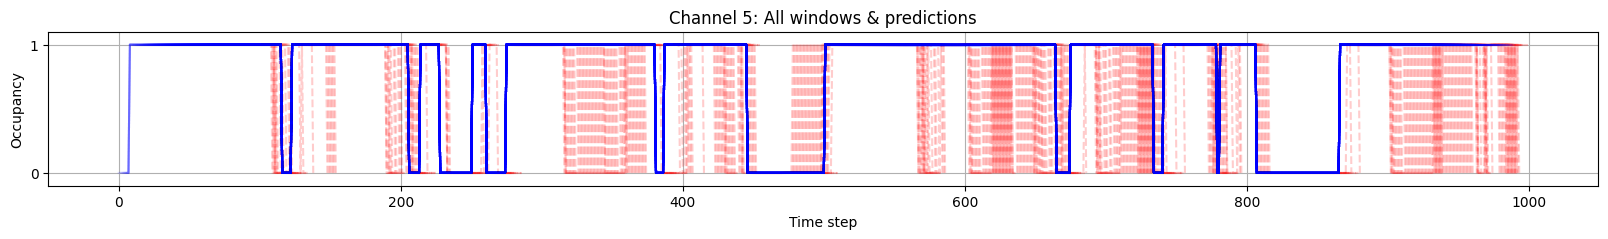

In [ ]:
# Sliding window that directly overlays each input window & its future prediction, without trying to rebuild the full 1000 step timeline
# It does not reconstruct the full signal, not a full usable timeline
preds_binary_np = preds_binary.cpu().numpy()
num_channels = X_raw.shape[0]
num_samples, horizon, _ = preds_binary_np.shape

for i in range(num_channels):
    plt.figure(figsize=(20, 2))
    for w in range(num_samples):
        start_input = w
        end_input = w + 100
        start_pred = end_input
        end_pred = start_pred + horizon

        # Input windows (optional, alpha very low to avoid clutter)
        plt.plot(range(start_input, end_input), X_raw[i, start_input:end_input], color='blue', alpha=0.1)

        # Predictions (dashed, very faint)
        plt.plot(range(start_pred, end_pred), preds_binary_np[w, :, i], '--', color='red', alpha=0.2)

    plt.title(f"Channel {i+1}: All windows & predictions")
    plt.xlabel("Time step")
    plt.ylabel("Occupancy")
    plt.ylim(-0.1, 1.1)
    plt.yticks([0, 1])
    plt.grid(True)
    plt.show()


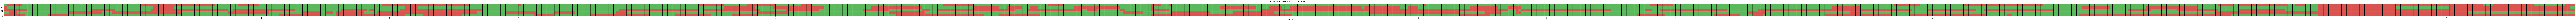

In [ ]:
# HEATMAP - One long scrollable axis

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pred_full_np = pred_full       # shape (5, time_steps)
X_raw_np = X_raw               # shape (5, time_steps)

# Ensure binary predictions
pred_bin = (pred_full_np >= 0.5).astype(int)

# Correctness matrix: 1 = correct, 0 = incorrect
correct_matrix = (pred_bin == X_raw_np).astype(int)

# Make blocks big + scrollable
plt.figure(figsize=(400, 50))  # <-- increase width here

ax = sns.heatmap(
    correct_matrix,
    cmap=["#d9534f", "#5cb85c"],   # red wrong, green correct
    cbar=False,
    linewidths=1,
    linecolor="black",
    square=True  # ensures blocks are large squares
)

ax.set_xlabel("Time step", fontsize=16)
ax.set_ylabel("Channel", fontsize=16)

ax.set_yticks(np.arange(correct_matrix.shape[0]) + 0.5)
ax.set_yticklabels([f"Ch {i+1}" for i in range(correct_matrix.shape[0])], fontsize=14)

# Reduce xtick clutter: only show every 50th time step
ax.set_xticks(np.arange(0, correct_matrix.shape[1], 50))
ax.set_xticklabels(np.arange(0, correct_matrix.shape[1], 50), rotation=90, fontsize=10)

plt.title("Prediction Accuracy Heatmap (Large, Scrollable)", fontsize=18, pad=20)
plt.tight_layout()
plt.show()



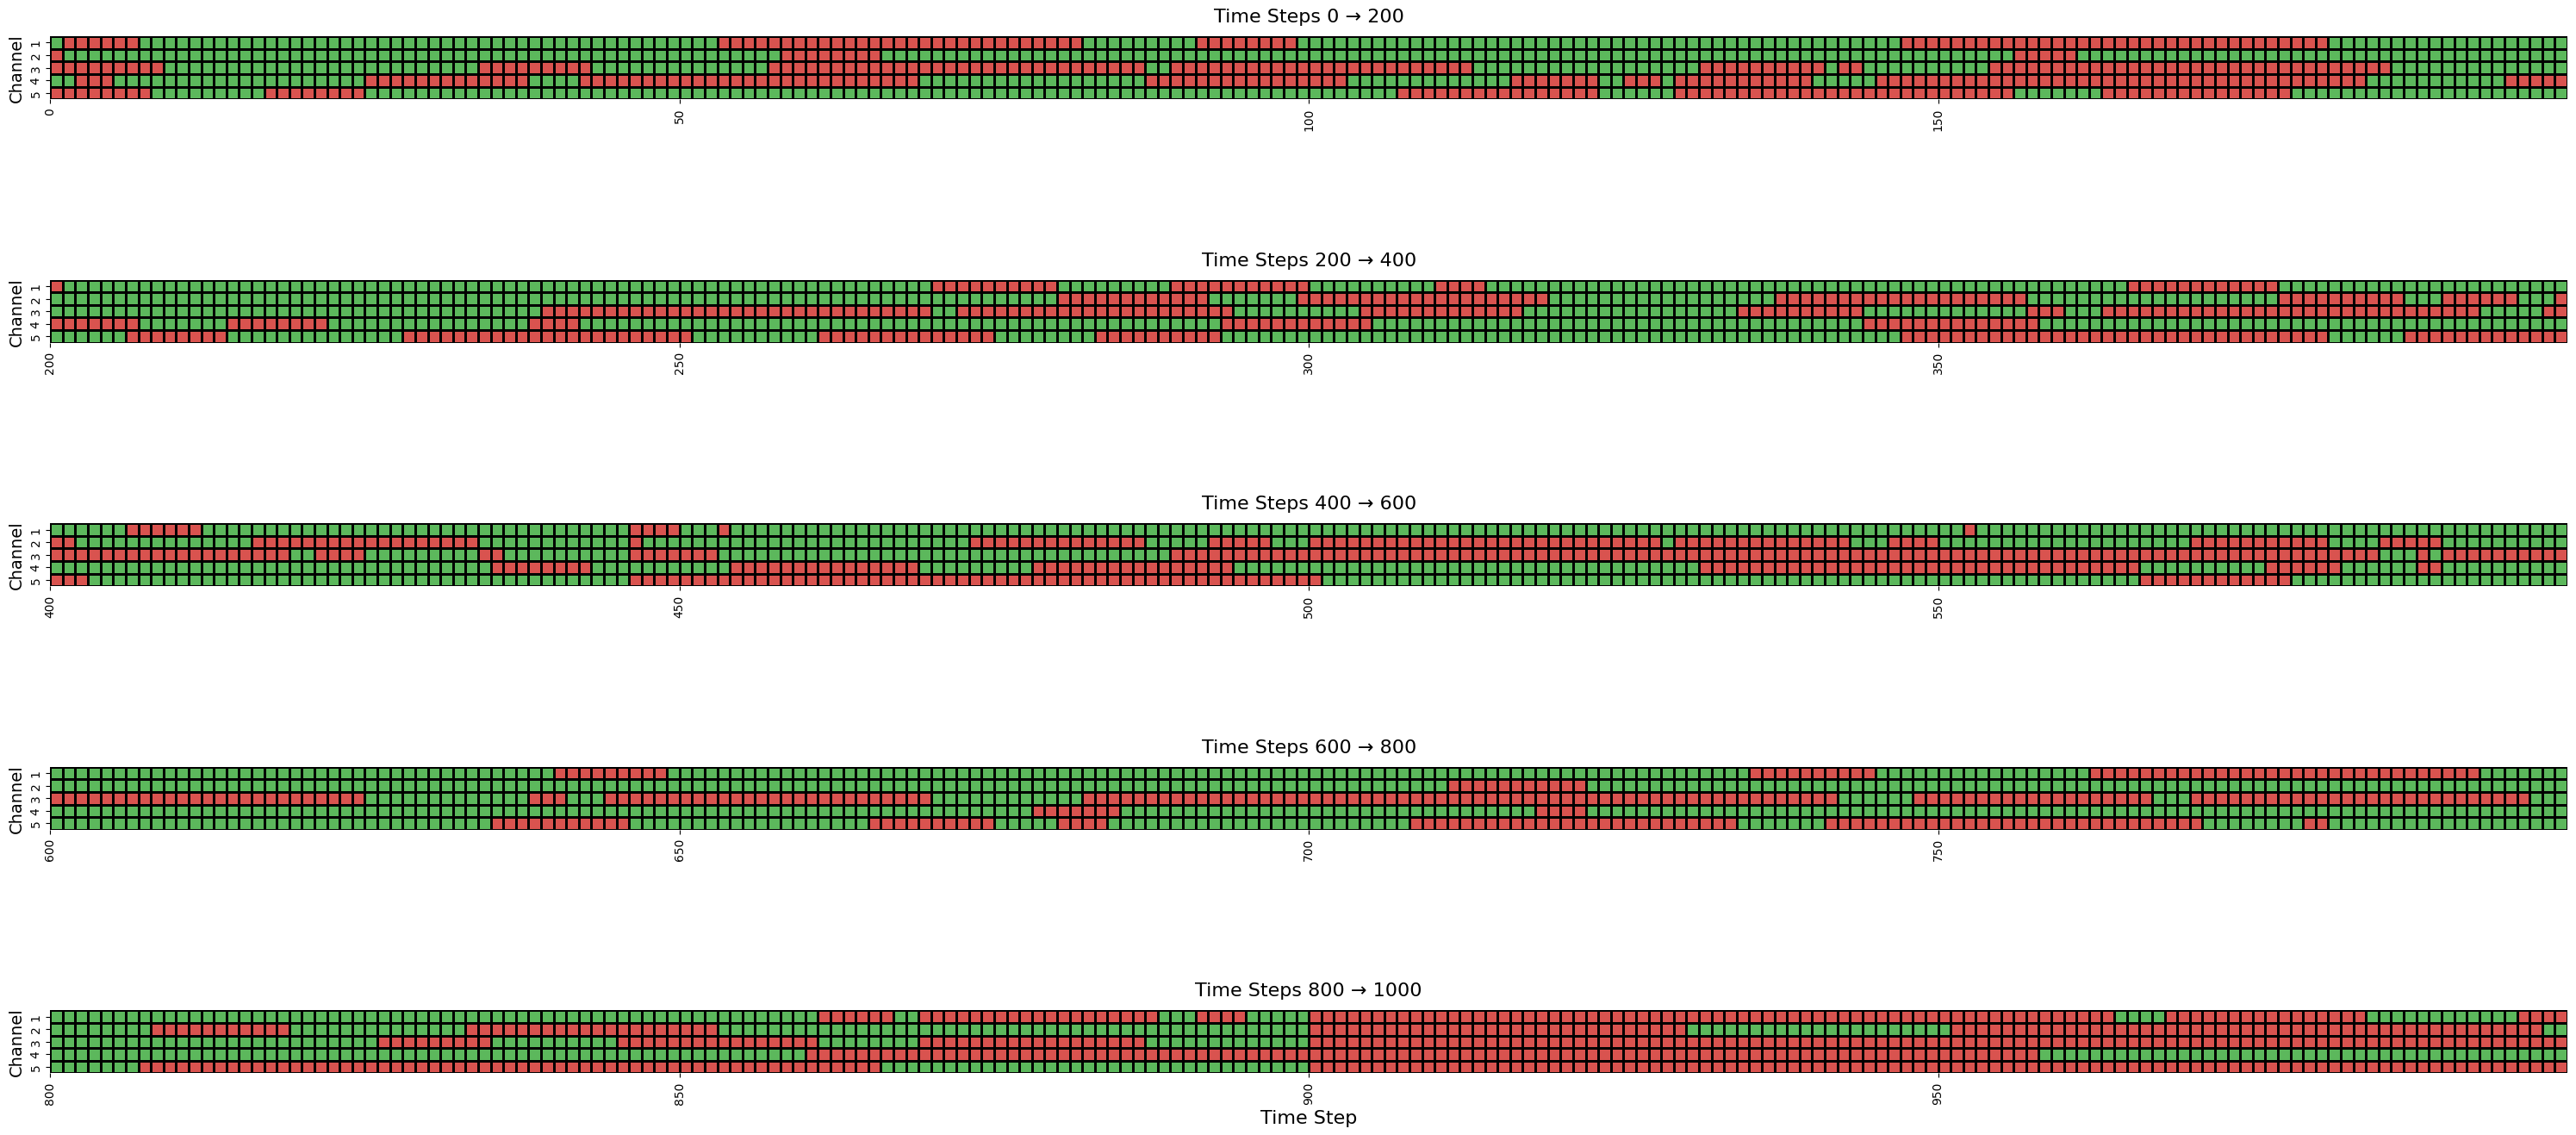

In [ ]:
# HEATMAP - Subgraphed for every 200 steps
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pred_full_np = pred_full       # shape (5, T)
X_raw_np = X_raw               # shape (5, T)

# Ensure binary predictions
pred_bin = (pred_full_np >= 0.5).astype(int)

# Correctness matrix: 1 = correct, 0 = incorrect
correct_matrix = (pred_bin == X_raw_np).astype(int)

segment_length = 200
time_steps = correct_matrix.shape[1]
num_segments = (time_steps + segment_length - 1) // segment_length  # ceil division

plt.figure(figsize=(30, num_segments * 3))  # height scales per segment

for seg in range(num_segments):
    start = seg * segment_length
    end = min(start + segment_length, time_steps)

    ax = plt.subplot(num_segments, 1, seg + 1)

    sns.heatmap(
        correct_matrix[:, start:end],
        cmap=["#d9534f", "#5cb85c"],   # red = incorrect, green = correct
        cbar=False,
        linewidths=1,
        linecolor="black",
        square=True
    )

    ax.set_ylabel("Channel", fontsize=14)
    ax.set_yticks(np.arange(correct_matrix.shape[0]) + 0.5)
    ax.set_yticklabels([str(i+1) for i in range(correct_matrix.shape[0])], fontsize=10)

    ax.set_xticks(np.arange(0, end - start, 50))
    ax.set_xticklabels(np.arange(start, end, 50), rotation=90, fontsize=10)

    ax.set_title(f"Time Steps {start} → {end}", fontsize=16, pad=12)

plt.xlabel("Time Step", fontsize=16)
plt.tight_layout()
plt.show()


# 8. Sample data compared with predicted data

In [ ]:
sample_id = random.randint(0, len(test_y_tensor)-1)  # Gets a random sample

# Get tensors for selected sample
actual = test_y_tensor[sample_id].cpu().int().numpy()       # shape: (horizon, num_channels)
predicted = preds_binary[sample_id].cpu().numpy()           # shape: (horizon, num_channels)

# Print comparison per channel
print(f"\nSample Index: {test_indices[sample_id]}")
print(f"X - incorrect prediction")
print(f"O - correct prediction\n")
horizon = actual.shape[0]
num_channels = actual.shape[1]

for ch in range(num_channels):
    actual_str = " ".join(str(actual[t, ch]) for t in range(horizon))
    predicted_str = " ".join(str(predicted[t, ch]) for t in range(horizon))
    correct_str = " ".join("O" if predicted[t, ch] == actual[t, ch] else "X" for t in range(horizon))

    print(f"Channel {ch+1}")
    print(f"Real:      {actual_str}")
    print(f"Predicted: {predicted_str}")
    print(f"Correct:   {correct_str}")
    print()

NameError: name 'test_indices' is not defined

In [ ]:
# torchviz
# Model and input setup
num_channels = 5
horizon = 10
hidden_size = 256
batch_size = 64
seq_length = 100

model = LSTM_model(num_channels=num_channels, horizon=horizon, hidden_size=hidden_size)

# Generate the clean model graph with output shapes
graph = draw_graph(
    model,
    input_size=(batch_size, seq_length, num_channels),  # Input shape: [64, 100, 5]
    device="cpu",
    expand_nested=True,
    depth=3,               # Show internal layers clearly
    save_graph=True,
    graph_name="lstm_training_flow",
    hide_module_functions=False
)

# Display the PNG inline in Colab or Jupyter
graph.visual_graph

In [ ]:
# test vision graph
batch_size = 64
seq_length = 50          # <-- choose your sequence length
num_channels = 5        # <-- this must match what you used to init your model

model = LSTM_model(num_channels=num_channels)

model_graph = draw_graph(
    model,
    input_size=(batch_size, seq_length, num_channels),  # (B, T, C)
    device='cpu',   # use cpu, not "meta", since LSTM allocates buffers
    expand_nested=True
)

model_graph.visual_graph

In [ ]:
# torchinfo
summary(model)